[View in Colaboratory](https://colab.research.google.com/github/olley102/linalgebra/blob/master/ShapeTransformationsExample.ipynb)

In [0]:
import math
import random
from fractions import Fraction
import copy
import matplotlib.pyplot as plt


"""Matrix class"""
class Mat(object):
  m = 1  # vertical length
  n = 1  # horizontal length
  values = []
  is_float = False


  def __init__(self, vals:list):
    # False for int, True for float:
    vals_float = False

    m_temp = len(vals)
    n_temp = len(vals[0])

    for row in vals:
      if len(row) != n_temp:
        raise TypeError
      for num in row:
        if type(num) == float:
          vals_float = True
        elif type(num) != int:
          raise TypeError
    
    self.values = vals[:]
    self.m = m_temp
    self.n = n_temp

    if vals_float:
      self.makefloat()


  def __repr__(self):
    text = ""
    for row in self.values:
      text += "{}\n".format(row)
    return text


  def zeros(vert_num, hor_num):  # no need for self here
    return Mat([[0]*hor_num for i in range(vert_num)])
  

  def ones(vert_num, hor_num):
    return Mat([[1]*hor_num for i in range(vert_num)])


  def identity(num):
    temp_mat = Mat.zeros(num, num)
    for row_num in range(num):
      temp_mat.values[row_num][row_num] = 1
    return temp_mat


  def randuniform(vert_num, hor_num, start=0, stop=1):  # returns float
    new_values = [[random.uniform(start, stop) for i in range(hor_num)]
      for j in range(vert_num)
    ]
    return Mat(new_values)


  def randint(vert_num, hor_num, start, stop):  # inclusive
    new_values = [[random.randint(start, stop) for i in range(hor_num)]
      for j in range(vert_num)
    ]
    return Mat(new_values)


  def _check_float(obj):  # no need for self in private method
    if obj.is_float:
      return True

    for row in obj.values:

      for val in row:
        if type(val) == float:
          obj.is_float = True
          return True
        elif type(val) != int:
          raise TypeError
    
    return False


  def makefloat(self):  # makes elements all float
    self.is_float = True
    for row_num in range(self.m):
        self.values[row_num] = list(map(
          float, self.values[row_num]
        ))
    return
  

  def _add(val1, val2):  # used for map
    return val1 + val2
  

  def _mul(val1, val2):
    return val1 * val2


  def __add__(self, other):
    temp_mat = self.copy()

    if type(other) == type(temp_mat):

      if temp_mat.m == other.m and temp_mat.n == other.n:
        for row_num in range(len(temp_mat.values)):
          temp_mat.values[row_num] = list(map(
            Mat._add,
            temp_mat.values[row_num], other.values[row_num]
          ))
      else:
        raise TypeError

    elif type(other) in (int, float):

      for row_num in range(len(temp_mat.values)):
        temp_mat.values[row_num] = list(map(
          lambda x: x + other,
          temp_mat.values[row_num]
        ))

    else:
      raise TypeError
    
    if Mat._check_float(temp_mat):
      temp_mat.makefloat()
    
    return temp_mat


  def __sub__(self, other):
    return self + other * -1


  def power(self, other):
    if type(other) not in (int, float):
      raise TypeError
    temp_mat = self.copy()

    for row_num in range(len(temp_mat.values)):
      temp_mat.values[row_num] = list(map(
        lambda x: x ** other,
        temp_mat.values[row_num]
      ))

    return temp_mat


  def _check_type(obj):
    classes = (
      "Mat",
      "Transformation2D",
      "Point2D"
    )
    return obj.__class__.__name__ in classes


  def _make_type(vals, new_type):
    if new_type == type(Point2D(0, 0)):
      return Point2D(vals[0][0], vals[1][0])
    
    return new_type(vals)


  def _check_mul_compat(obj, other):
    return obj.n == other.m and \
      Mat._check_type(obj) and Mat._check_type(other)


  def matmul(self, other):
    saved_type = type(self)  # to return correct type
    if other.__class__.__name__ == "Point2D" or \
      (
        self.__class__.__name__ == "Transformation2D" and
        not (other.m == other.n == 2)
      ):
      saved_type = type(other)
    
    new_values = [[0]*other.n for i in range(self.m)]
    other_tr = other.transpose()

    if Mat._check_mul_compat(self, other):

      for row_num in range(self.m):
        for col_num in range(other.n):
          new_values[row_num][col_num] = sum(map(
            Mat._mul,
            self.values[row_num], other_tr.values[col_num]
          ))

    else:
      raise TypeError

    return Mat._make_type(new_values, saved_type)


  def __mul__(self, other):
    temp_mat = None

    if type(other) == int or type(other) == float:
      temp_mat = self.simplemul(other)

      if Mat._check_float(temp_mat):
        temp_mat.makefloat()

    else:
      temp_mat = self.matmul(other)

    return temp_mat


  def simplemul(self, other):  # allows other to be Fraction
    temp_mat = self.copy()
    for row_num in range(len(temp_mat.values)):
      temp_mat.values[row_num] = list(map(
        lambda x: x * other,
        temp_mat.values[row_num]
      ))
    return temp_mat


  def hadprod(self, other):  # Hadamard product i.e. element-wise mul
    if type(self) != type(other) or \
      self.m != other.m or self.n != other.n:
      raise TypeError
    temp_mat = self.copy()
    
    for row_num in range(temp_mat.m):
      temp_mat.values[row_num] = list(map(
        Mat._mul,
        temp_mat.values[row_num], other.values[row_num]
      ))
    return temp_mat


  def dotprod(self, other):
    if type(self) != type(other) or \
      self.m != other.m or self.n != other.n or \
      (self.m != 1 and self.n != 1):  # check for vectors
      raise TypeError
    
    temp_mat = self.copy()
    other_temp = other.copy()

    if self.m == 1:
      other_temp = other_temp.transpose()
    else:
      temp_mat = temp_mat.transpose()

    temp_mat = temp_mat.matmul(other_temp)
    
    return temp_mat.values[0][0]


  def cofactors(self):
    if self.m <= 2:
      return self

    temp_mat = Mat.zeros(self.m, self.m)
    for row_num in range(self.m):
      for col_num in range(self.m):
        square = self.deepcopy()
        square.delcol(col_num)
        square.delrow(row_num)
        temp_mat.values[row_num][col_num] = \
          square.det() * (-1)**(row_num + col_num)
    return temp_mat


  def inverse(self):
    the_det = self.det()  # includes dimension validation
    if self.det() == 0:
      return
    
    the_adj = self.cofactors().transpose()

    return the_adj * (1/the_det)


  def fracinverse(self):  # returns Mat of Fraction
    the_det = self.det()
    if self.det() == 0:
      return
    
    the_adj = self.cofactors().transpose()

    return the_adj.simplemul(Fraction(1, the_det))


  def det(self):
    if self.m != self.n:
      raise TypeError
    if self.m == 1:
      return self.values[0][0]
    if self.m == 2:
      return self.values[0][0] * self.values[1][1] \
        - self.values[0][1] * self.values[1][0]
    
    dets = []
    for col_num in range(self.m):
      new_square = self.deepcopy()
      new_square.delrow(0)
      new_square.delcol(col_num)
      dets.append(new_square.det())
    
    return sum((-1)**i * dets[i] * self.values[0][i]
      for i in range(self.m)
    )


  def copy(self):
    saved_type = type(self)
    new_values = self.values[:]
    return Mat._make_type(new_values, saved_type)


  def deepcopy(self):
    saved_type = type(self)
    new_values = copy.deepcopy(self.values)
    return Mat._make_type(new_values, saved_type)


  def get(self, key1, key2):
    if key2 == "all":
      return self.values[key1]
    return self.values[key1][key2]


  def alter(self, key1, key2, val):
    self.values[key1][key2] = val
    if Mat._check_float(self):
      self.makefloat()
    return


  def delcol(self, col_num):
    for row_num in range(self.m):
      del self.values[row_num][col_num]
    self.n -= 1
    return
  

  def delrow(self, row_num):
    del self.values[row_num]
    self.m -= 1
    return


  def insert(self, vals:list, pos:int = 0, orientation:str = "r"):
    """
    pos - index of matrix at which to insert new values
    orientation - 'r' for row or 'c' for column
    """
    if orientation == "r":
      if len(vals) != self.n or pos < 0 or pos > self.m:
        raise TypeError
      self.values.insert(pos, vals)
      self.m += 1
    
    elif orientation == "c":
      if len(vals) != self.m or pos < 0 or pos > self.n:
        raise TypeError
      for row_num in range(self.n):
        self.values[row_num].insert(pos, vals[row_num])
      self.n += 1
    
    else:
      raise TypeError

    if Mat._check_float(self):
      self.makefloat()
    
    return
  

  def transpose(self):
    saved_type = type(self)
    if self.__class__.__name__ == "Point2D":
      saved_type = Mat
    new_values = list(map(list, zip(*self.values)))
    return saved_type(new_values)


"""Transformation matrix class for 2D plot"""
class Transformation2D(Mat):  # square 2 x 2


  def __init__(self, vals:list):
    super().__init__(vals)

    if not (self.m == self.n == 2):
      raise TypeError


  def applyunitsq(self):
    shape = Shape2D.unitsquare()
    shape.transform(self)
    return shape


"""Point class for 2D plot"""
class Point2D(Mat):  # vector 2 x 1


  def __init__(self, x, y):
    super().__init__([[x], [y]])


  def x(self):
    return self.get(0, 0)

  
  def y(self):
    return self.get(1, 0)


  def alter(self, x, y):
    super().alter(self, 0, 0, x)
    super().alter(self, 1, 0, y)
    return


  def plot(self):
    plt.plot(self.x(), self.y(), "o")
    plt.show()


"""Shape class for 2D plot"""
class Shape2D(object):
  points = []
  anchor = 0
  # anchor is point from which shape is drawn, rotated, etc


  def __init__(self, points:list):
    self.points = points


  def __repr__(self):
    ret_str = "Shape2D points:\n"

    for p in self.points:
      ret_str += p.transpose().__repr__()
    
    return ret_str


  def unitsquare():
    return Shape2D([
      Point2D(0, 0),
      Point2D(1, 0),
      Point2D(1, 1),
      Point2D(0, 1)
    ])


  def transform(self, t_mat):
    for p_num, p in enumerate(self.points):
      self.points[p_num] = t_mat * p
    return


  def translate(self, x, y):
    t_point = Point2D(x, y)  # translation vector
    for p_num in range(len(self.points)):
      self.points[p_num] += t_point
    return


  def setorigin(self):
    t_point = self.points[0]  # translation vector
    self.translate(-t_point.x(), -t_point.y())


  def _get_trig(degrees):
    rad = math.radians(degrees)
    sine = 0
    cosine = 0
    rem = degrees % 360

    if rem in (30, 150):
      sine = 0.5
      cosine = math.cos(rad)
    elif rem in (60, 300):
      sine = math.sin(rad)
      cosine = 0.5
    elif rem in (210, 330):
      sine = -0.5
      cosine = math.cos(rad)
    elif rem % 360 in (120, 240):
      sine = math.sin(rad)
      cosine = -0.5
    elif rem % 360 == 0:
      sine = 0
      cosine = 1
    elif rem % 360 == 90:
      sine = 1
      cosine = 0
    elif rem % 360 == 180:
      sine = 0
      cosine = -1
    elif rem % 360 == 270:
      sine = -1
      cosine = 0
    else:
      sine = math.sin(rad)
      cosine = math.cos(rad)
    
    return sine, cosine


  def reflect(self, degrees):
    """
    degrees is angle between line through anchor and
    line parallel to x axis
    """
    
    sin, cos = Shape2D._get_trig(2*degrees)

    saved_anchor = self.points[self.anchor]
    self.setorigin()

    t_mat = Transformation2D([
      [cos, sin],
      [sin, -cos]
    ])
    self.transform(t_mat)

    self.translate(saved_anchor.x(), saved_anchor.y())
    return


  def rotate(self, degrees):
    """
    degrees is anticlockwise from line parallel to x axis
    rotates about anchor
    """

    sin, cos = Shape2D._get_trig(degrees)

    saved_anchor = self.points[self.anchor]
    self.setorigin()

    t_mat = Transformation2D([
      [cos, -sin],
      [sin, cos]
    ])
    self.transform(t_mat)
    
    self.translate(saved_anchor.x(), saved_anchor.y())
    return


  def copy(self):
    return Shape2D(self.points[:])


  def deepcopy(self):
    new_points = []
    for p in self.points:
      new_points.append(p.deepcopy())
    return Shape2D(new_points)


  def plot(self):
    x = []
    y = []
    for p in self.points:
      x.append(p.x())
      y.append(p.y())

    plt.fill(x, y)
    plt.axis("scaled")
    plt.show()
    return


In [0]:
shape = Shape2D.unitsquare()

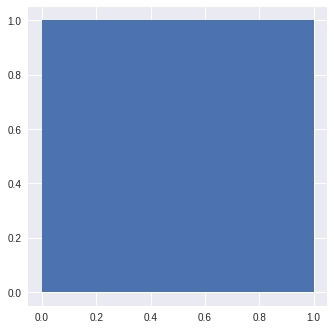

In [0]:
shape.plot()

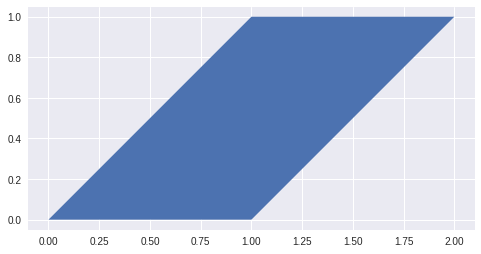

In [0]:
t_mat = Transformation2D([
    [1, 1],
    [0, 1]
])

shape.transform(t_mat)
shape.plot()

In [0]:
new_sq = Shape2D.unitsquare()
new_sq.reflect(30)
print(new_sq)

Shape2D points:
[0.0, 0.0]
[0.5, 0.8660254037844386]
[1.3660254037844386, 0.3660254037844386]
[0.8660254037844386, -0.5]



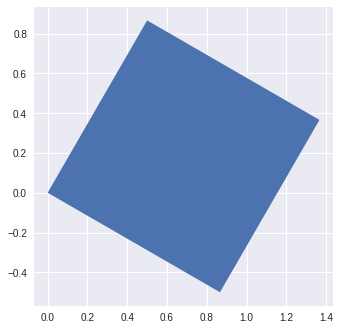

In [0]:
new_sq.plot()

In [0]:
new_sq.translate(5, 5)

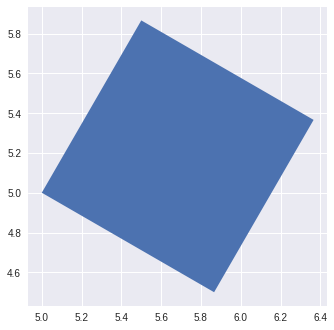

In [0]:
new_sq.plot()

In [0]:
new_sq.reflect(30)

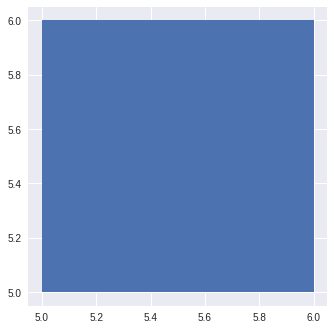

In [0]:
new_sq.plot()